## Conceptual description

Basis idee is een grid waarbij elke grid cell een agent is. Een agent heeft interactie met een random (=proportional to similarity) gekozen neighbor en neem dan een cultural trait over van zijn neighbor. Het originele model is van Axelrod (zie bijgevoegd paper). Er is ondertussen een hele literatuur (zie het Flache paper voor een recente review).  

discrete traits but implemented via numpy binary arrays



In [55]:
import collections
import random

import numpy as np

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

class CulturalDiff(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of grid
    seed : int
            random seed
    
    Attributes
    ----------
    height : int
    width : int
    density : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, seed=None):
        super().__init__(seed=seed)
        self.height = height
        self.width = width

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)
        self.datacollector = DataCollector(model_reporters={'diversity':calculate_nr_of_cultures})

        # Fill grid with agents with random traits
        
        # Note that this implementation does not guarantee some set distribution of traits. 
        # Therefore, examining the effect of minorities etc is not facilitated.
        for cell in self.grid.coord_iter():
            profile = np.asarray([self.random.choice([0,1]) for _ in range(4)])
            
            agent = CulturalDiffAgent(cell, self, profile)
            self.grid.position_agent(agent, cell)
            self.schedule.add(agent)


    def step(self):
        """
        Run one step of the model.
        """
        self.datacollector.collect(self)
        self.schedule.step()
        


class CulturalDiffAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    profile : ndarray
    
    """

    def __init__(self, pos, model, profile):
        super().__init__(pos, model)
        self.pos = pos
        self.profile = profile
        
    def step(self):
        
        #For each neighbor, calculate the similarity
        neighbor_similarity_dict = {}
        for neighbor in self.model.grid.neighbor_iter(self.pos, moore=True):
            neighbor_similarity = np.sum(self.profile==neighbor.profile)
            neighbor_similarity_dict[neighbor] = neighbor_similarity
        
        # Proportional to this similarity, pick a 'random' neighbor to interact with
        neighbors, weights = zip(*[(k,v) for k,v in neighbor_similarity_dict.items()])
        neighbor_to_interact = self.random.choices(neighbors, weights=weights)[0]
        
        # Select a trait that differs between the selected neighbor and self and
        # change that trait in self
        # we are using some numpy boolean indexing to make this short and easy
        not_same_features = self.profile != neighbor_to_interact.profile
        
        if np.any(not_same_features):
            index_for_trait = self.random.choice(np.nonzero(not_same_features)[0])
            self.profile[index_for_trait] = neighbor_to_interact.profile[index_for_trait]


def traits_to_color(profile):  
    """ Converts the traits of an agent to a list of RGBA values"""
    color = profile.copy().astype(float)
    if color[-1]==0:
        color[-1] = 0.2
    return color


def calculate_nr_of_cultures(model):
    diversity = collections.defaultdict(int)
    for (cell, i, j) in model.grid.coord_iter():
        if cell:
            diversity[tuple(cell.profile)] += 1

    return len(diversity.keys())

# Visualization

## Static images
### After initialization

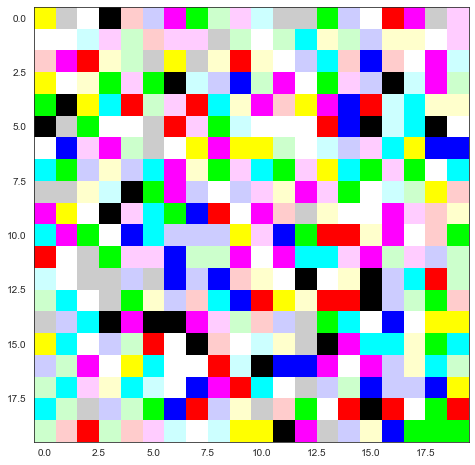

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import pandas as pd

model = CulturalDiff(seed=123456789)


def make_image(model):
    grid = np.zeros((model.height, model.width, 4))

    for (cell, i, j) in model.grid.coord_iter():
        color = [0,0,0,0] #in case not every cell is filled, the default colour is white
        if cell is not None:
            color = traits_to_color(cell.profile)
        grid[i,j] = color  
    return grid

def plot_model(model, ax):
    grid = make_image(model)
       
    image = ax.imshow(grid)
    return image
    
fig, ax = plt.subplots()
image = plot_model(model, ax)

plt.show()

In [57]:
for _ in range(250):
    model.step()

<AxesSubplot:>

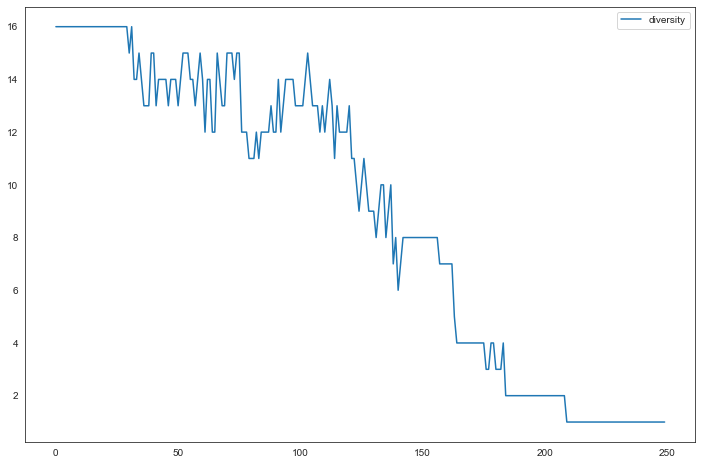

In [59]:
model.datacollector.get_model_vars_dataframe().plot()

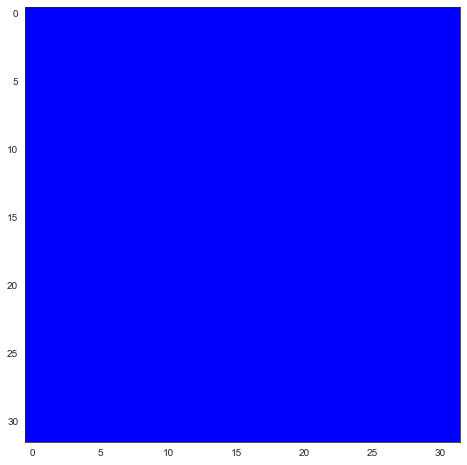

In [29]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation

model = CulturalDiff(32, 32, seed=987654321)
agents = model.schedule.agents


sns.set_style('white')

fig, ax = plt.subplots()
image = plot_model(model, ax)

def update(frame):
    model.step()
    grid = make_image(model)
    image.set_array(grid)
    return [image]

anim = FuncAnimation(fig, update, frames=500);
writervideo = animation.FFMpegWriter(fps=12) 
anim.save("diffusion.mp4", writer=writervideo)


In [30]:
from IPython.display import Video

Video("diffusion.mp4", width=600)